In [1]:
!git clone https://github.com/pshakhmin/deepfakes

Cloning into 'deepfakes'...
remote: Enumerating objects: 403, done.
remote: Counting objects: 100% (265/265), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 403 (delta 37), reused 253 (delta 31), pack-reused 138
Receiving objects: 100% (403/403), 269.50 MiB | 13.74 MiB/s, done.
Resolving deltas: 100% (97/97), done.
Updating files: 100% (222/222), done.


In [2]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.9 MB/s eta 0:00:00


In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets, models
from tqdm.notebook import tqdm
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision



import optuna
from optuna.trial import TrialState
from deepfakes.models.ConvNet import ConvNet

torch.manual_seed(69)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(69)

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

val_dir = '/content/drive/MyDrive/Курсовая2курс/Classification/DataSet_with_generated_fakes'
validation_dataloader = datasets.ImageFolder(val_dir, transform=transform)
valid_loader = torch.utils.data.DataLoader(validation_dataloader, batch_size = 64,
                                          shuffle=False, num_workers=2, drop_last = True)

In [7]:
def distillation_loss(_student_output, _teacher_output, _t=2.0):
    """Loss function for knowledge distillation"""
    teacher_probs = torch.sigmoid(_teacher_output / _t)
    student_probs = torch.sigmoid(_student_output / _t)
    return nn.functional.mse_loss(student_probs, teacher_probs) * _t ** 2

In [11]:
def load_trained_resnet(fp='/content/drive/MyDrive/Курсовая2курс/Classification/discriminator_final.pth'):
    """Loads a pretrained resnet34 for knowledge distillation"""
    resnet = models.resnet34(pretrained=True)
    resnet.fc = nn.Sequential(
        nn.Linear(resnet.fc.in_features, 1),
        nn.Sigmoid()
    )

    resnet.load_state_dict(torch.load(fp, map_location=device))

    resnet = resnet.to(device)
    return resnet

In [12]:
def validate_model(_model, _testloader):
    """Uses a dataloader to validate the model. Outputs model's accuracy on a given dataset"""
    _model.eval()
    class_correct = [0, 0]
    class_total = [0, 0]
    # classes = ['Real', 'Fake']
    _model.eval()
    with torch.no_grad():
        for data in tqdm(_testloader, leave=False, position=0):
            images, labels = data
            images = images.to(device)

            y_pred = _model(images)
            predicted = torch.squeeze(torch.round(y_pred))
            c = predicted.cpu().detach() == labels

            for i, label in enumerate(labels):
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print(class_correct, class_total)
    _acc = sum(class_correct) / sum(class_total)
    return _acc

In [13]:
teacher_model = load_trained_resnet()
model = teacher_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 71.2MB/s]


In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.000947829)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=580, gamma=0.10962742, verbose=False)
loss_fn = nn.BCEWithLogitsLoss()

accs = []

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [15]:
for epoch in tqdm(range(2), leave=False):
    model.eval()
    acc = validate_model(model, valid_loader)
    accs.append(acc)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[0, 7192] [1000, 7192]


  0%|          | 0/128 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[0, 7192] [1000, 7192]


Лучшая accuracy для подходов: 87.79


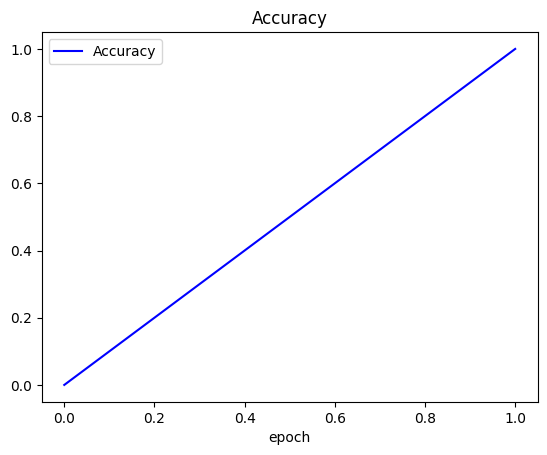

In [16]:
plt.plot(np.arange(len(accs)), color='blue', label='Accuracy')
print(f"Лучшая accuracy для подходов: {(max(accs) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [17]:
print(accs)

[0.8779296875, 0.8779296875]
